## LDA

In [1]:
%load_ext jupyter_tikz

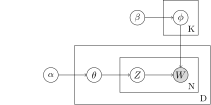

In [2]:
%%tikz
\usetikzlibrary{positioning, fit, backgrounds}

\begin{tikzpicture}[
    observed/.style={circle, draw=black, fill=gray!30, minimum size=15pt, inner sep=0pt},
    latent/.style={circle, draw=black, fill=white, minimum size=15pt, inner sep=0pt},
    plate/.style={rectangle, draw=black, inner sep=5pt, rounded corners=0pt},
    const/.style={circle, draw=black, fill=white, minimum size=15pt, inner sep=0pt, font=\small}
]

% ノード
\node[const] (alpha) {$\alpha$};
\node[latent, right=of alpha] (theta) {$\theta$};
\node[latent, right=of theta] (z) {$Z$};
\node[observed, right=of z] (w) {$W$};
\node[latent, above=1.5cm of w] (phi) {$\phi$};
\node[const, left=of phi] (beta) {$\beta$};

% 矢印
\draw[->] (alpha) -- (theta);
\draw[->] (theta) -- (z);
\draw[->] (beta) -- (phi);
\draw[->] (z) -- (w);
\draw[->] (phi) -- (w);

% プレート：単語 N
\node[plate, fit=(z)(w), inner sep=10pt] (plateN) {};
% プレート：文書 M
\node[plate, fit=(theta)(plateN), inner sep=12pt] (plateD) {};
% プレート：トピック K
\node[plate, fit=(phi), inner sep=10pt] (plateK) {};
% 右下にラベルKをノードとして配置
\node[anchor=south east, font=\small] at (plateK.south east) {K};
\node[anchor=south east, font=\small] at (plateN.south east) {N};
\node[anchor=south east, font=\small] at (plateD.south east) {D};

\end{tikzpicture}

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [phi, theta]
>BinaryGibbsMetropolis: [z_0, z_1, z_2]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

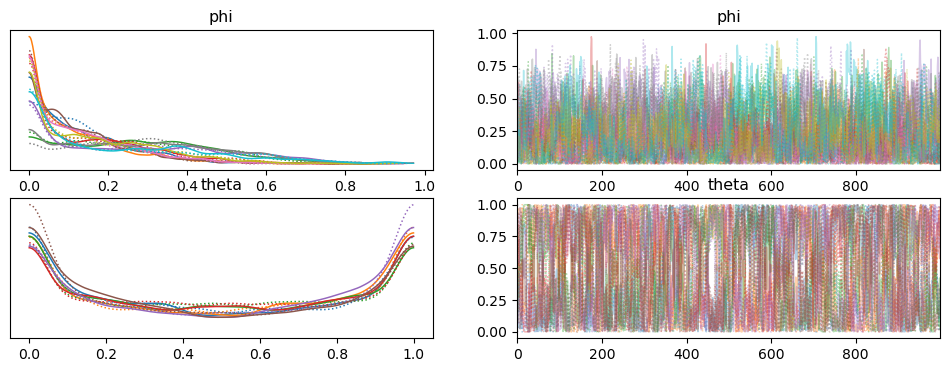

In [3]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az

# データ（例として文書ごとの単語出現を数値化したBag-of-Words行列）
# 文書×単語行列（D=3, V=5）
documents = np.array([
    [1, 2, 3, 0, 0],
    [0, 0, 2, 3, 1],
    [1, 0, 1, 0, 4]
])

D, V = documents.shape
K = 2

alpha = np.ones(K) * 0.5  # 文書トピック分布のディリクレハイパーパラメータ
beta = np.ones(V) * 0.5   # トピック単語分布のディリクレハイパーパラメータ

with pm.Model() as lda_model:
    # トピック単語分布 φ (K×V)
    phi = pm.Dirichlet('phi', a=beta, shape=(K, V))

    # 文書ごとのトピック分布 θ (D×K)
    theta = pm.Dirichlet('theta', a=alpha, shape=(D, K))

    # 各文書のトピック割当（潜在変数） z
    z = []
    w_obs = []
    for d in range(D):
        # 文書 d の単語数
        N_d = int(documents[d].sum())
        # トピック z をサンプリング
        z_d = pm.Categorical(f'z_{d}', p=theta[d], shape=N_d)
        z.append(z_d)

        # 生成される単語の分布はトピック z_d に基づく
        w_d = pm.Categorical(
            f'w_{d}',
            p=phi[z_d],
            observed=np.repeat(np.arange(V), documents[d])
        )
        w_obs.append(w_d)

    # サンプリング
    trace = pm.sample(1000, tune=1000, target_accept=0.9, chains=2, random_seed=42)

# トレースの確認
az.plot_trace(trace, var_names=['phi', 'theta'])

In [10]:
# 実際MCMCでやると遅いので普通は使わない

In [4]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification

In [5]:
X, _ = make_multilabel_classification(random_state=0)

In [6]:
X

array([[3., 1., 4., ..., 4., 1., 3.],
       [5., 0., 6., ..., 0., 0., 3.],
       [3., 4., 1., ..., 3., 2., 5.],
       ...,
       [2., 1., 2., ..., 1., 0., 3.],
       [6., 4., 1., ..., 1., 3., 5.],
       [2., 4., 2., ..., 5., 4., 2.]])

In [7]:
lda = LatentDirichletAllocation(n_components=5,random_state=0)

In [8]:
lda.fit(X)

LatentDirichletAllocation(n_components=5, random_state=0)

In [9]:
lda.transform(X[-2:])

array([[0.00360392, 0.25499205, 0.0036211 , 0.64236448, 0.09541846],
       [0.15297572, 0.00362644, 0.44412786, 0.39568399, 0.003586  ]])